In [1]:
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches, Plots
# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, StableRNGs, SimpleDiffEq
gr()

rng = StableRNG(1111)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

In [2]:
function cannabis_t!(du, u, p, t)
    β, γ, s, N = p
    du[1] = - β * (u[1] * u[3])/N
    du[2] =  (β * (u[1] * u[3])/N) - (s * u[2])
    du[3] = s * u[2] - γ * u[3]
    du[4] = γ * u[3]
end

cannabis_t! (generic function with 1 method)

In [3]:
#time interval: forcasted over one year period
tspan_t = (0,365)

#initial conditions for oregon
u0_oregon_t = [3305059;165252.95;1817;0]

#initial conditions for colorado
u0_colorado_t = [4108732;205436.60;2259.80;0]

#initial conditions for vermont 
u0_vermont_t = [327200;16360;179;0]

#parameter values for oregon
p_oregon_t = [0.05, 0.032, 0.011, 3472129.73]

#parameter values for colorado
p_colorado_t = [0.05, 0.078, 0.011, 431642.40]

#parameter values for vermont
p_vermont_t = [0.05, 0.012, 0.011, 343739.96]

#problem definition for oregon
prob_oregon_t = ODEProblem(cannabis_t!, u0_oregon_t, tspan_t, p_oregon_t)

#problem definition for colorado
prob_colorado_t = ODEProblem(cannabis_t!, u0_colorado_t, tspan_t, p_colorado_t)

#problem definition for vermont
prob_vermont_t = ODEProblem(cannabis_t!, u0_vermont_t, tspan_t, p_vermont_t)

#setting up auto switching betwen stiff and non-stiff
tsidas_alg = AutoVern7(Rodas5())

#forecast for oregon
solution_oregon_t = solve(prob_oregon_t, Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

#forecast for colorado
solution_colorado_t = solve(prob_colorado_t, Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

#forecast for vermont
solution_vermont_t = solve(prob_vermont_t, Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

retcode: Success
Interpolation: 1st order linear
t: 1461-element Vector{Float64}:
   0.0
   0.25
   0.5
   0.75
   1.0
   1.25
   1.5
   1.75
   2.0
   2.25
   2.5
   2.75
   3.0
   ⋮
 362.25
 362.5
 362.75
 363.0
 363.25
 363.5
 363.75
 364.0
 364.25
 364.5
 364.75
 365.0
u: 1461-element Vector{Vector{Float64}}:
 [327200.0, 16360.0, 179.0, 0.0]
 [327197.60620628874, 16317.46243054282, 223.32780896458993, 0.6035542037965694]
 [327194.68648457085, 16275.566883541787, 267.40691373705306, 1.339718150280862]
 [327191.2437931592, 16234.308641617816, 311.2398157388318, 2.207749484127901]
 [327187.28106311936, 16193.683027556734, 354.8289960002426, 3.206913323647532]
 [327182.801198466, 16153.685404002706, 398.1769153314104, 4.336482199867451]
 [327177.8070763584, 16114.311173153556, 441.2860144918791, 5.5957359961277255]
 [327172.3015472949, 16075.555776458032, 484.1587143588906, 6.983961888182481]
 [327166.2874353059, 16037.414694315084, 526.7974160942312, 8.500454284801501]
 [327159.767538

In [4]:
X_oregon_t = Array(solution_oregon_t)
X_colorado_t = Array(solution_colorado_t)
X_vermont_t = Array(solution_vermont_t)

t_oregon = Array(solution_oregon_t.t)
t_colorado = Array(solution_oregon_t.t)
t_vermont = Array(solution_oregon_t.t)
noise_magnitude = 5e-3

susceptible_oregon = X_oregon_t[1, :]
endemic_oregon = X_oregon_t[2, :]
users_oregon = X_oregon_t[3, :]
treatment_oregon = X_oregon_t[4, :]
x̄_oregon = mean(X_oregon_t, dims = 2)
Xnoise_oregon_t = X_oregon_t .+ (noise_magnitude * x̄_oregon) .* randn(rng, eltype(X_oregon_t), size(X_oregon_t))

susceptible_colorado = X_colorado_t[1, :]
endemic_colorado = X_colorado_t[2, :]
users_colorado = X_colorado_t[3, :]
treatment_colorado = X_colorado_t[4, :]
x̄_colorado = mean(X_colorado_t, dims = 2)
Xnoise_colorado_t = X_colorado_t .+ (noise_magnitude * x̄_colorado) .* randn(rng, eltype(X_colorado_t), size(X_colorado_t))

susceptible_vermont = X_vermont_t[1, :]
endemic_vermont = X_vermont_t[2, :]
users_vermont = X_vermont_t[3, :]
treatment_vermont = X_vermont_t[4, :]
x̄_vermont = mean(X_vermont_t, dims = 2)
Xnoise_vermont_t = X_vermont_t .+ (noise_magnitude * x̄_vermont) .* randn(rng, eltype(X_vermont_t), size(X_vermont_t))

4×1461 Matrix{Float64}:
     3.26725e5      3.2829e5      3.29405e5  …  62964.0        62716.8
 16331.3        16321.9       16230.4           76981.8        77077.3
   254.306        367.622        95.2813        67403.4        67696.0
  -314.51        -111.309       -36.3065            1.38143e5      1.38112e5

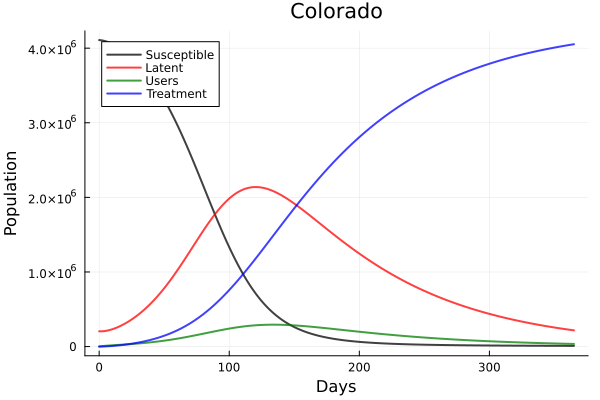

In [5]:
plot(t_colorado,susceptible_colorado, ylabel="Population", xlabel="Days" , title="Colorado", alpha = 0.75, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_colorado,endemic_colorado, alpha = 0.75, color = :red, label = ["Latent" nothing], linewidth=2)
plot!(t_colorado,users_colorado, alpha = 0.75, color = :green, label = ["Users" nothing], linewidth=2)
plot!(t_colorado,treatment_colorado, alpha = 0.75, color = :blue, label = ["Treatment" nothing], linewidth=2)

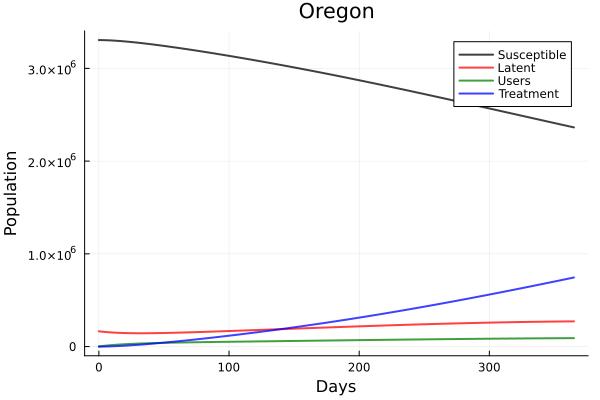

In [6]:
plot(t_oregon, susceptible_oregon, ylabel="Population", xlabel="Days" , title="Oregon", alpha = 0.75, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_oregon, endemic_oregon, alpha = 0.75, color = :red, label = ["Latent" nothing], linewidth=2)
plot!(t_oregon, users_oregon, alpha = 0.75, color = :green, label = ["Users" nothing], linewidth=2)
plot!(t_oregon,treatment_oregon, alpha = 0.75, color = :blue, label = ["Treatment" nothing], linewidth=2)

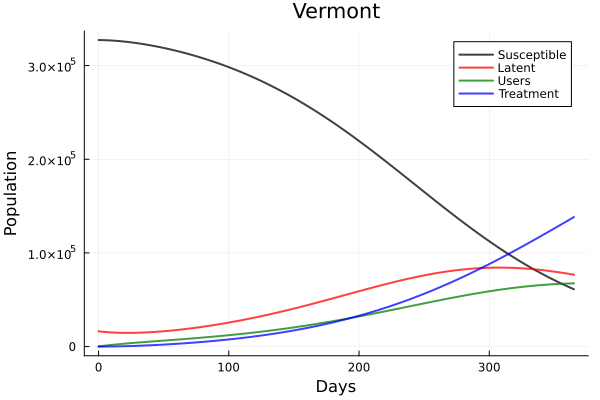

In [7]:
plot(t_vermont,susceptible_vermont, ylabel="Population", xlabel="Days" , title="Vermont", alpha = 0.75, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_vermont,endemic_vermont, alpha = 0.75, color = :red, label = ["Latent" nothing], linewidth=2)
plot!(t_vermont,users_vermont, alpha = 0.75, color = :green, label = ["Users" nothing], linewidth=2)
plot!(t_vermont,treatment_vermont, alpha = 0.75, color = :blue, label = ["Treatment" nothing], linewidth=2)


In [8]:
# Define the ReLU activation function
# function myrelu(x)
#     return max(0, x)
# end
# rbf(x) = exp.(-(x .^ 2))
# rbf(x) = myrelu(x)
const U = Lux.Chain(Lux.Dense(4, 16, relu),Lux.Dense(16, 1))

# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)
const _st = st

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [9]:
# Define the hybrid model (Neural Network)
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, _st)[1] # Network prediction
    du[1] = -p_true[1] * (u[1] * u[3])/p_true[4]
    du[2] =  (p_true[1] * (u[1] * u[3])/p_true[4]) - (p_true[3] * û[1])
    du[3] = p_true[3] * u[2] - p_true[2] * u[3]
    du[4] = u[3] * û[1]
end

ude_dynamics! (generic function with 1 method)

In [24]:
nn_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_oregon_t)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!,Xnoise_oregon_t[:, 1], tspan_t, p)
#setting up auto switching betwen stiff and non-stiff

function predict(θ, X = Xnoise_oregon_t[:, 1], T = t_oregon)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
                force_dtmin=true,
                maxiters = 70000,
                abstol = 1e-6, reltol = 1e-6,
            sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end

predict (generic function with 3 methods)

In [25]:
function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xnoise_oregon_t .- X̂)
end

losses = Float64[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

#19 (generic function with 1 method)

In [26]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float32}(p))

res1 = Optimization.solve(optprob, OptimizationOptimisers.Adam(), callback = callback, maxiters = 70000000, abstol = 1e-20, reltol = 1e-11)
println("Training loss after $(length(losses)) iterations: $(losses[end])")

optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2,  LBFGS(linesearch = HagerZhang()), callback = callback, maxiters = 2000000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/gZRU3/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/gZRU3/src/integrator_interface.jl:589


LoadError: DomainError with 364.875:
integrand produced NaN in the interval (364.75, 365.0)

In [ ]:
# Rename the best candidate
p_trained = res2.u

# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10,
                 xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
      xlabel = "Iterations", ylabel = "Loss", label = "LBFGS", color = :red)